**Thorough analysis of bias and variance in the linear regression**

I had trouble to clearly understand the connection between the definitions of the [variance](https://en.wikipedia.org/wiki/Variance) and the [bias of an estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) in my probability courses and the explanation in the machine learning courses I then followed. In the first case, the mathematical definitions seem thorough without any room for ambiguity, conversely to the second case where estimator bias and variance were regularly explained with visual explanations, like the well known illustration from [Understanding the Bias-Variance Tradeoff Scott Fortmann-Roe's article](http://scott.fortmann-roe.com/docs/BiasVariance.html), or with general rules like the following extracts: "[Both bias and variance are connected to the model’s complexity. Low complexity means high bias and low variance. Increased complexity means low bias and high variance](https://medium.com/swlh/how-bias-and-variance-affect-a-machine-learning-model-6d258d9221db)" or "[The bias-variance tradeoff is a tradeoff between a complicated and simple model, in which an intermediate complexity is likely best](https://towardsdatascience.com/bias-variance-and-regularization-in-linear-regression-lasso-ridge-and-elastic-net-8bf81991d0c5)". The "[Bias and variance in linear models](https://towardsdatascience.com/bias-and-variance-in-linear-models-e772546e0c30)" illustrates the bias and variance changes when adding regularization. At first glance I was satisfied with these two explanations, from my probability and my machine learning courses. But then, I started being annoyed with this second non-mathematical definition. So I decided to thoroughly study the linear regression to better understand the connection between the two definitions.

In this notebook, I have analyzed the change of the bias and variance when adding explanatory variables (also named features) for a linear regression model. From the machine learning general explanations, I expect the bias to reduce and the variance to increase. However, what do improving or worsening the bias and the variance mean when the estimators are not a single scalar? Can we compare the bias and the covariance of two vector estimators? In this notebook, the analysis of the bias and variance of a vector estimator and of a single estimator are studied for the linear regression model when increasing the number of explanatory variables.

___
# Packages

In [1]:
%load_ext nb_black
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

___
# Data
To illustrate my results, I built a dataset with some independent variables $X$ and a dependent variable, a.k.a. a target, depending linearly on the independent variables by means of a set of coefficients $\beta$. I have deliberately chosen some coefficients with a 0 value to consider the case when a useless explanatory variable is added to the linear regression model. The measured target is then the product of the independent variables and the coefficients plus some noise $\epsilon \sim \mathcal{N}(0,\sigma^{2}I)$:
$$Y=X\beta+\epsilon$$

## Parameters

In [2]:
np.random.seed(4)  # from reproducibility purpose
m = 100
sigma_noise = 10
beta = np.array([1, 0, 0, 2, -1, 5, 0, 0])

<IPython.core.display.Javascript object>

## Independent variables
Some arbitrary independent variables.

In [3]:
X = np.concatenate(
    (
        np.ones((m, 1)),
        np.random.gamma(1, scale=1.0, size=(m, 1)),
        np.random.normal(1, scale=1.0, size=(m, 1)),
        np.random.gamma(1, scale=1.0, size=(m, 1)),
        np.random.normal(1, scale=1.0, size=(m, 1)),
        np.random.normal(0, scale=1.0, size=(m, 1)),
        np.random.normal(0, scale=1.0, size=(m, 1)),
        np.random.normal(0, scale=1.0, size=(m, 1)),
    ),
    axis=1,
)

<IPython.core.display.Javascript object>

## Dependent variable

In [4]:
X_beta = np.matmul(X, beta)

<IPython.core.display.Javascript object>

___
# Functions

In [5]:
def get_beta_hat(X0, y, alpha):
    """
    Get beta statistic.
    When alpha=0, this is equivalent to the ordinary least squares parameter estimation.
    When alpha>0, this is equivalent to the paremeter estimation with L2 regularized least squares.
    """
    X0t_X0 = np.matmul(X0.T, X0)
    X0t_X0_alphaI = X0t_X0 + alpha * np.eye(X0t_X0.shape[0])
    X0t_X0_alphaI_1 = np.linalg.inv(X0t_X0_alphaI)
    beta_hat = np.matmul(np.matmul(X0t_X0_alphaI_1, X0.T), y)
    return beta_hat


def get_y_hat(X0, beta_hat):
    """
    Get target statistic.
    """
    return np.matmul(X0, beta_hat)


def get_cov_mat(X0, alpha, sigma_noise):
    """
    Get covariance matrix of target statistic.
    """
    X0t_X0 = np.matmul(X0.T, X0)
    X0t_X0_alphaI = X0t_X0 + alpha * np.eye(X0t_X0.shape[0])
    X0t_X0_alphaI_1 = np.linalg.inv(X0t_X0_alphaI)
    XO_X0t_X0_alphaI_1_XOt = np.matmul(X0, np.matmul(X0t_X0_alphaI_1, X0.T))
    cov_mat = sigma_noise ** 2 * np.matmul(
        XO_X0t_X0_alphaI_1_XOt, XO_X0t_X0_alphaI_1_XOt
    )
    return cov_mat


def get_biases(X0, X_beta, alpha):
    """
    Get vector of biases of target statistic.
    """
    X0t_X0 = np.matmul(X0.T, X0)
    X0t_X0_alphaI = X0t_X0 + alpha * np.eye(X0t_X0.shape[0])
    X0t_X0_alphaI_1 = np.linalg.inv(X0t_X0_alphaI)
    XO_X0t_X0_alphaI_1_XOt = np.matmul(X0, np.matmul(X0t_X0_alphaI_1, X0.T))
    return np.matmul(
        XO_X0t_X0_alphaI_1_XOt - np.eye(XO_X0t_X0_alphaI_1_XOt.shape[0]), X_beta
    )


def get_expected_mse_var_term(X0, alpha, p0):
    """
    Get mse var term.
    """
    if alpha == 0:
        return p0
    else:
        d, P = np.linalg.eig(np.matmul(X0.T, X0))
        D_1 = np.diag(1 / d)
        D_aI_1 = np.diag(1 / (d + alpha))
        Pt_X0t = np.matmul(P.T, X0.T)
        Pt_X0t_2 = Pt_X0t ** 2
        return np.dot(
            d / ((d + alpha) ** 2), np.matmul((Pt_X0t_2), np.ones(Pt_X0t_2.shape[1]))
        )


def get_common_results(X, x_cols, X_beta, alpha, sigma_noise):
    """
    Get common results, the fixed values or the expectations of random variables.
    """
    p0 = len(x_cols)
    X0 = X[:, x_cols]
    biases = get_biases(X0, X_beta, alpha)
    cov_mat = get_cov_mat(X0, alpha, sigma_noise)
    return p0, X0, biases, cov_mat

<IPython.core.display.Javascript object>

In [6]:
def make_experimentation(n, sigma_noise, m, X_beta, X0, alpha):
    """
    Perform n experimentations and return n target and MSE statistics.
    """
    y_hat_list = []
    mse_list = []
    for i in range(n):
        error = np.random.normal(scale=sigma_noise, size=m)
        y = X_beta + error
        beta_hat = get_beta_hat(X0, y, alpha)
        y_hat = get_y_hat(X0, beta_hat)
        y_hat_list.append(y_hat)
        mse = np.sum((y_hat - X_beta) ** 2)
        mse_list.append(mse)
    return y_hat_list, mse_list

<IPython.core.display.Javascript object>

___
# Bias and variance analysis for vector estimators
In this first section, let's look at the change of the bias and the variance of a vector estimator when adding new explanatory variables. This is a tool to compare vector estimators, this is the [mean squared error of an estimator](https://en.wikipedia.org/wiki/Mean_squared_error#Estimator). When the estimator is a scalar the definition is clear. However, when the estimator is multidimensional, I have found the two following definitions: $E[(\hat{\theta}-\theta)(\hat{\theta}-\theta)^{T})]$[[1]](https://cermics.enpc.fr/~delmas/Enseig/ensta_cours.pdf) which is a matrix and $E[\lVert(\hat{\theta}-\theta)\rVert^{2}]$[[2]](http://theanalysisofdata.com/notes/estimators1.pdf)[[3]](https://lerasle.perso.math.cnrs.fr/docs/PC4Corrige.html) which is a scalar. Since I wasn't able so far to get rid of one the two definitions, I considered them both, first the matrix definition and secondly the scalar definition. When considering the MSE matrix, the comparison of two estimators can be performed by analyzing the sign of the difference of the two MSE matrices. If the resulting matrix is positive then the second vector estimator is better. If it is negative, then the first vector estimator is better. If the resulting is neither positive nor negative, nothing can be concluded.

$$\begin{align}
MSE&=E[(\hat{Y} - X\beta)(\hat{Y} - X\beta)^{T}]\\
&=E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}] + (E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}\\
&= MSE_{var} + MSE_{bias} \\
\\
MSE_{var}&=E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}] \\
MSE_{bias}&=(E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}
\end{align}$$

## MSE matrix
In the linear regression case, the MSE matrix is:  
$$\begin{align}
MSE&=E[(\hat{Y} - X\beta)(\hat{Y} - X\beta)^{T}]\\
&=E[(\hat{Y} - E[\hat{Y}] + E[\hat{Y}] - X\beta)(\hat{Y} - E[\hat{Y}] + E[\hat{Y}] - X\beta)^{T}]\\
&=E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}] + E[(E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}] + E[(\hat{Y} - E[\hat{Y}])(E[\hat{Y}] - X\beta)^{T}] + E[(E[\hat{Y}] - X\beta)(\hat{Y} - E[\hat{Y}])^{T}]\\
&=E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}] + E[(E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}] + (E[\hat{Y}] - E[\hat{Y}])(E[\hat{Y}] - X\beta)^{T} + (E[\hat{Y}] - X\beta)(E[\hat{Y}] - E[\hat{Y}])^{T}\\
&=E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}] + E[(E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}]\\
&=\underbrace{E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}]}_\text{MSE_{var}} + \underbrace{(E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}}_\text{MSE_{bias}}
\end{align}$$

Considering the following notation:
$$\begin{align}
MSE_{var}&=E[(\hat{Y} - E[\hat{Y}])(\hat{Y} - E[\hat{Y}])^{T}] \\
MSE_{bias}&=(E[\hat{Y}] - X\beta)(E[\hat{Y}] - X\beta)^{T}
\end{align}$$

### Frequentist approach
In the frequentist approach, the parameter estimation depends on the considered independent variables. Let's assume, only a subset $X_0$ (with $p_{0}$ columns) of $X$ has been selected. The estimated parameters are then:
$$\hat{\beta_{0}}=(X_{0}^{T}X_{0})^{-1}X_{0}^{T}Y$$

And consequently, the estimated predictions are:
$$\hat{Y_{0}}=X_{0}\hat{\beta_{0}}=X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}Y$$

The expected value of $\hat{Y_{0}}$ is then:
$$E[\hat{Y_{0}}]=X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}X\beta$$

___
* **$MSE_{var}$**

Let's derive the variance term of the MSE:
$$\begin{align}
\hat{Y_{0}} - E[\hat{Y_{0}}] &= X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}Y - E[\hat{Y_{0}}]\\
&= X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}\epsilon
\end{align}$$

Hence:
$$\begin{align}
MSE_{var}(X_{0}) &= E[(X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}\epsilon)(X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}\epsilon)^{T}] \\
&= X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T} E[\epsilon \epsilon^{T}] X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T} \\
&= X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T} \sigma^{2} I X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T} \\
&= \sigma^{2} X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}
\end{align}$$

Let's compare $MSE_{var}(X_{0})$ and $MSE_{var}(X_{1})$, with $X_{1}$ including $X_{0}$ (for instance $X_{1}=\begin{pmatrix} X_{0} & x_{p_{0}+1} \end{pmatrix}$). We can show that $MSE_{var}(X_{1}) - MSE_{var}(X_{0})$ is positive. Let's note $E_{i} = \{X_{i}u | u \in \mathbb{R}^{p_{i}}\}$. $X_{i}(X_{i}^{T}X_{i})^{-1}X_{i}^{T}$ is a projector, so $u^{T}X_{i}(X_{i}^{T}X_{i})^{-1}X_{i}^{T}u = ||u_{E_{i}}||^{2}$.
$$\begin{align}
\forall u \in \mathbb{R}^{n} \quad u^{T} \sigma^{2} (X_{1}(X_{1}^{T}X_{1})^{-1}X_{1}^{T} - X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}) u &= \sigma^{2} (||u_{E_{1}}||^{2} - ||u_{E_{0}}||^{2}) \\
&= \sigma^{2}  ( (||u||^{2} - ||u_{E_{1}^{\bot}}||^{2}) - (||u||^{2} - ||u_{E_{0}^{\bot}}||^{2})) \\
&= \sigma^{2}  ( ||u_{E_{0}^{\bot}}||^{2} - ||u_{E_{1}^{\bot}}||^{2} ) \\
&= \sigma^{2}  ( \min\limits_{v\in\mathbb{R}^{p_{0}}}(||u - X_{0}v||^{2} - \min\limits_{v\in\mathbb{R}^{p_{1}}}(||u - X_{1}v||^{2} )
\end{align}$$

Since $X_{1}$ contains $X_{0}$, then the result of the second minimization problem is lower than (or equal to) the first one. The MSE matrix resulting from the two estimator MSE matrix difference is then positive. The matrix $\sigma^{2} X_{1}(X_{1}^{T}X_{1})^{-1}X_{1}^{T}$ is then greater than the matrix $\sigma^{2} X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}$.

**The variance term of the MSE matrix then increase when adding new independent variable, whether this is a useful one variable ($\beta_{i} \neq 0$) or not ($\beta_{i} = 0$).**

___
* **$MSE_{bias}$**

Let derive the bias term of the MSE:
$$E[\hat{Y_{0}}] - X\beta = (X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}-I)X\beta$$

Hence:
$$\begin{align}
MSE_{bias} &= (X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}-I)X\beta ((X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}-I)X\beta)^{T} \\
&= (X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}-I)X\beta \beta^{T}X^{T} (X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}-I)
\end{align}$$

**Unfortunately, nothing can be concluded for this term.**

In [7]:
# parameters
alpha = 0  # since we are in a frequentist approach without regularization

# initialization
mse_mat_bias_list = []
mse_mat_var_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    _, X0, biases, _ = get_common_results(X, x_cols, X_beta, alpha, sigma_noise)
    mse_mat_bias_list.append(
        np.matmul(
            np.reshape(biases, (len(biases), 1)), np.reshape(biases, (1, len(biases)))
        )
    )
    mse_mat_var_list.append(get_cov_mat(X0, alpha, sigma_noise))

<IPython.core.display.Javascript object>

#### $MSE_{var}$ increases when adding explanatory variable

In [8]:
for ii in range(0, X.shape[1] - 1):
    eigvals = np.linalg.eigvals(mse_mat_var_list[ii + 1] - mse_mat_var_list[ii])
    print(np.min(eigvals), np.max(eigvals))

(-1.15094384258883e-14+0j) (99.9999999999997+0j)
(-1.7658427167671792e-14+0j) (100.00000000000004+0j)
(-2.9363277131202554e-14+0j) (99.99999999999997+0j)
(-3.281628950474632e-13+0j) (100.00000000000006+0j)
(-8.352266027704196e-14+0j) (99.99999999999987+0j)
(-2.3187862086841947e-13+0j) (100.00000000000011+0j)
(-4.1487064488299177e-14-5.1414772292082595e-15j) (100.00000000000017+0j)


<IPython.core.display.Javascript object>

#### $MSE_{bias}$ does not increase of decrease when adding explanatory variable

In [9]:
for ii in range(0, X.shape[1] - 1):
    eigvals = np.linalg.eigvals(mse_mat_bias_list[ii + 1] - mse_mat_bias_list[ii])
    print(np.min(eigvals), np.max(eigvals))

(-94.44303714738214+0j) (90.6643423058386+0j)
(-133.3040850229547+0j) (125.87485202627272+0j)
(-727.2280381028207+0j) (538.1279597151861+0j)
(-570.2210474561782+0j) (440.68785767074365+0j)
(-1939.9621997920299+0j) (3.053566645191639e-14+0j)
(-5.537875687571283e-28+0j) (8.140146006108649e-28+0j)
(-9.362310256271155e-28+0j) (5.434455097821107e-28+0j)


<IPython.core.display.Javascript object>

### Bayesian approach
In the bayesian approach, the results are the following:
$$\hat{\beta_{0}}=(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}Y$$
$$\hat{Y_{0}}=X_{0}\hat{\beta_{0}}=X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}Y$$
The expected value of $\hat{Y_{0}}$ is then:
$$E[\hat{Y_{0}}]=X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}X\beta$$

___
* **$MSE_{var}$**

Let's compare the variance term in the bayesian approach vs in the frequentist approach.
$$\begin{align}
\hat{Y_{0}} - E[\hat{Y_{0}}] &= X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}Y - E[\hat{Y_{0}}]\\
&= X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}\epsilon
\end{align}$$

Hence:
$$\begin{align}
MSE_{var}(X_{0}) &= E[(X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}\epsilon)(X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}\epsilon)^{T}] \\
&= X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T} E[\epsilon \epsilon^{T}] X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T} \\
&= X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T} \sigma^{2} I X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T} \\
&= \sigma^{2}X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T} X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}
\end{align}$$

**Unfortunately, nothing can be concluded for this term.**

___
* **$MSE_{bias}$**

Let derive the bias term of the MSE:
$$E[\hat{Y_{0}}] - X\beta = (X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}-I)X\beta$$

Hence:
$$\begin{align}
MSE_{bias} &= (X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}-I)X\beta ((X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}-I)X\beta)^{T} \\
&= (X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}-I)X\beta \beta^{T}X^{T} (X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}-I)
\end{align}$$

**Unfortunately, nothing can be concluded for this term.**

In [10]:
# parameters
alpha = 40  # since we are in a frequentist approach without regularization

# initialization
mse_mat_bias_list = []
mse_mat_var_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    _, X0, biases, _ = get_common_results(X, x_cols, X_beta, alpha, sigma_noise)
    mse_mat_bias_list.append(
        np.matmul(
            np.reshape(biases, (len(biases), 1)), np.reshape(biases, (1, len(biases)))
        )
    )
    mse_mat_var_list.append(get_cov_mat(X0, alpha, sigma_noise))

<IPython.core.display.Javascript object>

#### $MSE_{var}$ does not increase of decrease when adding explanatory variable

In [11]:
for ii in range(0, X.shape[1] - 1):
    eigvals = np.linalg.eigvals(mse_mat_var_list[ii + 1] - mse_mat_var_list[ii])
    print(np.min(eigvals), np.max(eigvals))

(-3.267029962486426+0j) (46.748650742125186+0j)
(-2.292877523253305+0j) (47.53946785501041+0j)
(-1.2495557385860738+0j) (41.22918650958304+0j)
(-1.0279344778987423+0j) (49.028793803920976+0j)
(-0.037390864780485526+0j) (43.78267737127335+0j)
(-0.2797828810320388+0j) (48.14628628697182+0j)
(-0.3320741414618705+0j) (45.417980988033534+0j)


<IPython.core.display.Javascript object>

#### $MSE_{bias}$ does not increase of decrease when adding explanatory variable

In [12]:
for ii in range(0, X.shape[1] - 1):
    eigvals = np.linalg.eigvals(mse_mat_bias_list[ii + 1] - mse_mat_bias_list[ii])
    print(np.min(eigvals), np.max(eigvals))

(-107.07955970917595+0j) (113.38069863891053+0j)
(-79.57954124689562+0j) (84.02201418468508+0j)
(-594.4019294824184+0j) (386.4089629314528+0j)
(-291.24919186893703+0j) (207.58430762086232+0j)
(-1767.8758822188888+0j) (25.971031084769667+0j)
(-41.89459345878093+0j) (41.84231402122852+0j)
(-25.616209563136383+0j) (25.440386019080304+0j)


<IPython.core.display.Javascript object>

## MSE scalar
In this part, I have considered the scalar definition of the MSE. The MSE value breaks down to two terms linked to the variance and bias.
$$\begin{align}
MSE&=E[||\hat{Y} - X\beta||^{2}]\\
&=E[||\hat{Y} - E[\hat{Y}] + E[\hat{Y}] - X\beta||^{2}]\\
&=E[||\hat{Y} - E[\hat{Y}]||^{2}] + E[||E[\hat{Y}] - X\beta||^{2}] + 2E[(\hat{Y} - E[\hat{Y}])^{T}(E[\hat{Y}] - X\beta)]\\
&=\underbrace{E[||\hat{Y} - E[\hat{Y}]||^{2}]}_\text{MSE_{var}} + \underbrace{||E[\hat{Y}] - X\beta||^{2}}_\text{MSE_{bias}}
\end{align}$$

Considering the following notation:
$$\begin{align}
MSE_{var}=E[||\hat{Y} - E[\hat{Y}]||^{2}]\\
MSE_{bias}=||E[\hat{Y}] - X\beta||^{2}
\end{align}$$

### Frequentist approach
In the frequentist approach, the parameter estimation depends on the considered independent variables. Let's assume, only a subset $X_0$ (with $p_{0}$ columns) of $X$ has been selected. The estimated parameter is then:
$$\hat{\beta_{0}}=(X_{0}^{T}X_{0})^{-1}X_{0}^{T}Y$$
And consequently, the estimated prediction is:
$$\hat{Y_{0}}=X_{0}\hat{\beta_{0}}=X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}Y$$

The expected value of $\hat{Y_{0}}$ is then:
$$E[\hat{Y_{0}}]=X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}X\beta$$

___
* **$MSE_{var}$**

Let derive the variance term of the MSE:
$$\begin{align}
\hat{Y_{0}} - E[\hat{Y_{0}}] &= X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}Y - E[\hat{Y_{0}}]\\
&= X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}\epsilon
\end{align}$$
Since $X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}$ is a projector of rank $p_{0}$ (since all variables are assumed to be linearly independent), by means of Cochran theorem, we have the following result:
$$\frac{||\hat{Y_{0}} - E[\hat{Y_{0}}]||^{2}}{\sigma^{2}}\sim\chi^{2}(p_{0})$$
Then:
$$\boxed{E[||\hat{Y_{0}} - E[\hat{Y_{0}}]||^{2}]=\sigma^{2}p_{0}}$$
**$MSE_{var}$ increases when $p_{0}$ increases, whether a new useful independent variable is added or not.**

___
* **$MSE_{bias}$**

Let derive the bias term of the MSE:
$$E[\hat{Y_{0}}] - X\beta = (X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}-I)X\beta$$

$I-X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}$ is as also a projector of rank $m-p_{0}$. Then:
$$\boxed{||E[\hat{Y_{0}}] - X\beta||^{2}=\min\limits_{u\in\mathbb{R}^{p_{0}}}(||X\beta-X_{0}u||^{2})}$$
**$MSE_{bias}$ decreases when a new variable is added in $X_{0}$, whether this new variable is useful or not.** This may be suprising, at least it was for me at the beginning, that when adding a new useless variable this term decreases.

In [13]:
# parameters
alpha = 0  # since we are in a frequentist approach without regularization
n_exp = 10

# initialization
mse_mean_observed_list = []
mse_expected_list = []
mse_bias_list = []
mse_mean_observed_var_list = []
mse_expected_var_list = []
p0_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    p0, X0, biases, _ = get_common_results(X, x_cols, X_beta, alpha, sigma_noise)
    p0_list.append(p0)

    y_hat_list, mse_list = make_experimentation(
        n_exp, sigma_noise, m, X_beta, X0, alpha
    )

    mse_mean_observed_list.append(np.mean(mse_list))
    mse_expected_list.append(np.sum(biases ** 2) + sigma_noise ** 2 * p0)
    mse_bias_list.append(np.sum(biases ** 2))
    mse_mean_observed_var_list.append(np.mean(mse_list) - np.sum(biases ** 2))
    mse_expected_var_list.append(sigma_noise ** 2 * p0)

<IPython.core.display.Javascript object>

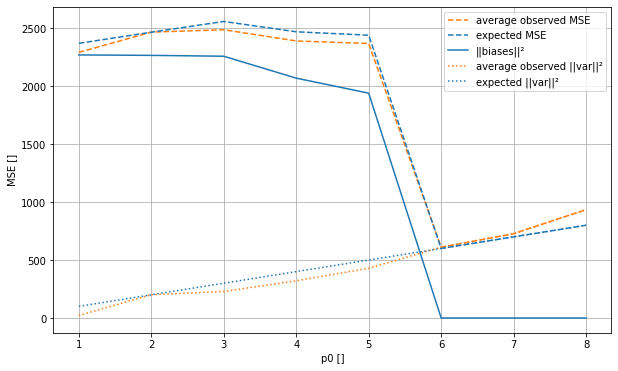

<IPython.core.display.Javascript object>

In [14]:
linestyle_bias = "-"
linestyle_var = ":"
linestyle_total = "--"
color_expected_val = "tab:blue"
color_observed_mean = "tab:orange"

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    p0_list,
    mse_mean_observed_list,
    label="average observed MSE",
    linestyle=linestyle_total,
    color=color_observed_mean,
)
ax.plot(
    p0_list,
    mse_expected_list,
    label="expected MSE",
    linestyle=linestyle_total,
    color=color_expected_val,
)
ax.plot(
    p0_list,
    mse_bias_list,
    label="||biases||²",
    linestyle=linestyle_bias,
    color=color_expected_val,
)
ax.plot(
    p0_list,
    mse_mean_observed_var_list,
    label="average observed ||var||²",
    linestyle=linestyle_var,
    color=color_observed_mean,
)
ax.plot(
    p0_list,
    mse_expected_var_list,
    label="expected ||var||²",
    linestyle=linestyle_var,
    color=color_expected_val,
)
ax.set_xlabel("p0 []")
ax.set_ylabel("MSE []")
ax.legend()
ax.grid()
plt.show()

As shown on the figure, the bias term of MSE decreases when new variables are added. Conversely the variance term increases. When increasing the number of experimentations, the average of observed values converge to the expected one. Surprisingly, even when an useless variable is added, the bias decreases and the variance increases.

### Bayesian approach
In the bayesian approach, the results are the following:
$$\hat{\beta_{0}}=(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}Y$$
$$\hat{Y_{0}}=X_{0}\hat{\beta_{0}}=X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}Y$$
The expected value of $\hat{Y_{0}}$ is then:
$$E[\hat{Y_{0}}]=X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}X\beta$$

Since $X_{0}^{T}X_{0}$ is symmetric, positive and definite (since all variables are assumed to be linearly independent), it can be diagonalized by an orthogonal matrix: $X_{0}^{T}X_{0}=PDP^{T}$. Thus, we can perform similarly on $X_{0}^{T}X_{0}+\alpha I$ by means of the same orthogonal matrix: $X_{0}^{T}X_{0}+\alpha I=P(D+\alpha I)P^{T}$.

___
* **$MSE_{var}$**

Let's compare the variance term in the bayesian approach vs in the frequentist approach.
$$\begin{align}
\hat{Y_{0}} - E[\hat{Y_{0}}] &= X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}Y - E[\hat{Y_{0}}]\\
&= X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}\epsilon\\
&= X_{0}P(D+\alpha I)^{-1}P^{T}X_{0}^{T}\epsilon
\end{align}$$

Then:
$$\begin{align}
||\hat{Y_{0}} - E[\hat{Y_{0}}]||^{2} &= (X_{0}P(D+\alpha I)^{-1}P^{T}X_{0}^{T}\epsilon)^{T}(X_{0}P(D+\alpha I)^{-1}P^{T}X_{0}^{T}\epsilon)\\
&=\epsilon^{T}X_{0}P(D+\alpha I)^{-1}D(D+\alpha I)^{-1}P^{T}X_{0}^{T}\epsilon
\end{align}$$

Hence, the expected value is (because $E[\epsilon_{i}\epsilon_{j}]=\delta_{ij}\sigma^{2}$):
$$\boxed{
\begin{align}
E[||\hat{Y_{0}} - E[\hat{Y_{0}}]||^{2}]&=\sum_{i=1}^{p_{0}}\frac{D_{i,i}}{(D_{i,i}+\alpha)^{2}}E[((P^{T}X_{0}^{T}\epsilon)_{i})^{2}]\\
&=\sum_{i=1}^{p_{0}}\frac{D_{i,i}}{(D_{i,i}+\alpha)^{2}}\sum_{j=1}^{m}((P^{T}X_{0}^{T})_{i,j})^{2}E[\epsilon_{j}^{2}]\\
&=\sum_{i=1}^{p_{0}}\frac{D_{i,i}}{(D_{i,i}+\alpha)^{2}}\sum_{j=1}^{m}((P^{T}X_{0}^{T})_{i,j})^{2}\sigma ^{2}
\end{align}
}$$

In the frequentist approach we had:
$$\begin{align}
||\hat{Y_{0}} - E[\hat{Y_{0}}]||^{2} &= (X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}\epsilon)^{T}(X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}\epsilon)\\
&= \epsilon^{T}X_{0}PD^{-1}P^{T}X_{0}^{T}\epsilon
\end{align}$$

And the expected value was:
$$\boxed{
\begin{align}
E[||\hat{Y_{0}} - E[\hat{Y_{0}}]||^{2}] &= \sum_{i=1}^{p_{0}}\frac{1}{D_{i,i}}E[((P^{T}X_{0}^{T}\epsilon)_{i})^{2}] \\
&= \sum_{i=1}^{p_{0}}\frac{1}{D_{i,i}}\sum_{j=1}^{m}((P^{T}X_{0}^{T})_{i,j})^{2}\sigma ^{2}
\end{align}
}$$

Moreover:
$$\begin{align}
\forall i: \frac{D_{i,i}}{(D_{i,i}+\alpha)^{2}}-\frac{1}{D_{i,i}} = \frac{D_{i,i}^{2}-(D_{i,i}+\alpha)^{2}}{(D_{i,i}+\alpha)^{2}D_{i,i}} < 0
\end{align}$$

**Thus the variance term of the MSE is lower in the bayesian approach than in the frequentist one.** It seem to increase when adding new feature. However I wasn't able to proove it.
$$\boxed{MSE_{var}^{bayesian}<MSE_{var}^{frequentist}}$$

___
* **$MSE_{bias}$**

Let derive the bias term of the MSE:
$$\begin{align}
||E[\hat{Y_{0}}] - X\beta||^{2} &= ||(X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}-I)X\beta||^{2}\\
&= ||X\beta||^{2} - 2\beta^{T}X^{T}X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}X\beta + \beta^{T}X^{T}X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}X_{0}(X_{0}^{T}X_{0}+\alpha I)^{-1}X_{0}^{T}X\beta\\
&= ||X\beta||^{2} + \beta^{T}X^{T}X_{0}P((D+\alpha I)^{-1}D(D+\alpha I)^{-1}-2(D+\alpha I)^{-1})P^{T}X_{0}X\beta\\
\end{align}$$
In the frequentist approach that was:
$$||E[\hat{Y_{0}}] - X\beta||^{2} = ||X\beta||^{2} + \beta^{T}X^{T}X_{0}P(-D^{-1})P^{T}X\beta$$

Subtituing the frequentist term to the bayesian one gives:
$$||E[\hat{Y_{0}}] - X\beta||^{2}_{bay} - ||E[\hat{Y_{0}}] - X\beta||^{2}_{freq} = \beta^{T}X^{T}X_{0}P((D+\alpha I)^{-1}D(D+\alpha I)^{-1}-2(D+\alpha I)-(-D^{-1})P^{T}X\beta$$

Moreover:
$$\begin{align}
\forall i: \frac{D_{i,i}}{(D_{i,i}+\alpha)^{2}} - 2\frac{1}{D_{i,i}+\alpha} - -\frac{1}{D_{i,i}} &= \frac{D_{i,i}^{2}-2D_{i,i}(D_{i,i}+\alpha)+(D_{i,i}+\alpha)^{2}}{(D_{i,i}+\alpha)^{2}D_{i,i}} \\
&= \frac{\alpha^{2}}{(D_{i,i}+\alpha)^{2}D_{i,i}} > 0
\end{align}$$

**Thus the bias term of the MSE is greater in the bayesian approach than in the frequentist one. It can increase when adding feature.**
$$\boxed{MSE_{bias}^{bayesian}>MSE_{bias}^{frequentist}}$$


In [15]:
# parameters
alpha = 40  # since we are in a bayesian approach with regularization
n_exp = 10

# initialization
mse_mean_observed_list = []
mse_expected_list = []
mse_bias_list = []
mse_mean_observed_var_list = []
mse_expected_var_list = []
p0_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    p0, X0, biases, _ = get_common_results(X, x_cols, X_beta, alpha, sigma_noise)
    p0_list.append(p0)
    mse_var = get_expected_mse_var_term(X0, alpha, p0)

    y_hat_list, mse_list = make_experimentation(
        n_exp, sigma_noise, m, X_beta, X0, alpha
    )

    mse_mean_observed_list.append(np.mean(mse_list))
    mse_expected_list.append(np.sum(biases ** 2) + sigma_noise ** 2 * mse_var)
    mse_bias_list.append(np.sum(biases ** 2))
    mse_mean_observed_var_list.append(np.mean(mse_list) - np.sum(biases ** 2))
    mse_expected_var_list.append(sigma_noise ** 2 * mse_var)

<IPython.core.display.Javascript object>

In [16]:
np.diff(mse_bias_list)

array([ 6.30113893e+00,  4.44247294e+00, -2.07992967e+02, -8.36648842e+01,
       -1.74190485e+03, -5.22794376e-02, -1.75823544e-01])

<IPython.core.display.Javascript object>

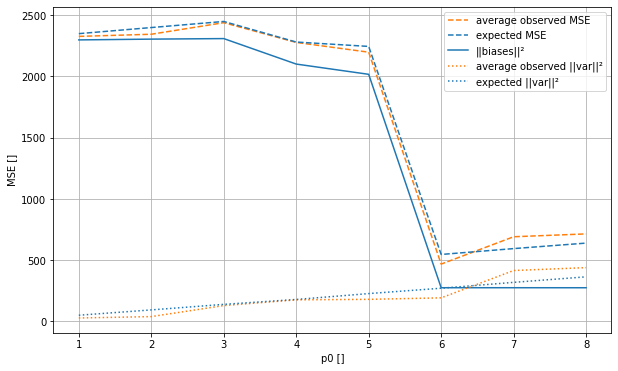

<IPython.core.display.Javascript object>

In [17]:
linestyle_bias = "-"
linestyle_var = ":"
linestyle_total = "--"
color_expected_val = "tab:blue"
color_observed_mean = "tab:orange"

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    p0_list,
    mse_mean_observed_list,
    label="average observed MSE",
    linestyle=linestyle_total,
    color=color_observed_mean,
)
ax.plot(
    p0_list,
    mse_expected_list,
    label="expected MSE",
    linestyle=linestyle_total,
    color=color_expected_val,
)
ax.plot(
    p0_list,
    mse_bias_list,
    label="||biases||²",
    linestyle=linestyle_bias,
    color=color_expected_val,
)
ax.plot(
    p0_list,
    mse_mean_observed_var_list,
    label="average observed ||var||²",
    linestyle=linestyle_var,
    color=color_observed_mean,
)
ax.plot(
    p0_list,
    mse_expected_var_list,
    label="expected ||var||²",
    linestyle=linestyle_var,
    color=color_expected_val,
)
ax.set_xlabel("p0 []")
ax.set_ylabel("MSE []")
ax.legend()
ax.grid()
plt.show()

When increasing the number of experimentations, the average of observed values converge to the expected one.

### Comparison frequentist vs bayesian approaches

In [18]:
# parameters
alpha_freq = 0
alpha_bay = 40
n_exp = 20

# initialization
mse_freq_expected_list = []
mse_freq_bias_list = []
mse_freq_expected_var_list = []
mse_bay_mean_observed_list = []
mse_bay_bias_list = []
mse_bay_mean_observed_var_list = []
p0_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    # frequentist approach
    p0, X0, biases, _ = get_common_results(X, x_cols, X_beta, alpha_freq, sigma_noise)
    p0_list.append(p0)

    y_hat_list, mse_list = make_experimentation(
        n_exp, sigma_noise, m, X_beta, X0, alpha
    )

    mse_freq_expected_list.append(np.sum(biases ** 2) + sigma_noise ** 2 * p0)
    mse_freq_bias_list.append(np.sum(biases ** 2))
    mse_freq_expected_var_list.append(sigma_noise ** 2 * p0)

    # bayesian approach
    p0, X0, biases, _ = get_common_results(X, x_cols, X_beta, alpha_bay, sigma_noise)

    y_hat_list, mse_list = make_experimentation(
        n_exp, sigma_noise, m, X_beta, X0, alpha
    )

    mse_bay_mean_observed_list.append(
        np.sum(biases ** 2)
        + sigma_noise ** 2 * get_expected_mse_var_term(X0, alpha_bay, p0)
    )
    mse_bay_bias_list.append(np.sum(biases ** 2))
    mse_bay_mean_observed_var_list.append(
        sigma_noise ** 2 * get_expected_mse_var_term(X0, alpha_bay, p0)
    )

<IPython.core.display.Javascript object>

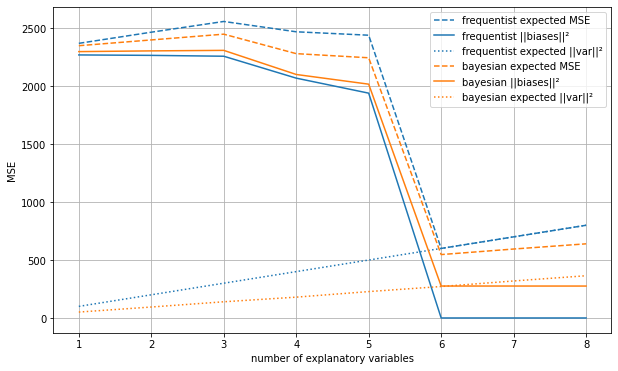

<IPython.core.display.Javascript object>

In [19]:
color_freq = "tab:blue"
color_bay = "tab:orange"
linestyle_bias = "-"
linestyle_var = ":"
linestyle_total = "--"

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    p0_list,
    mse_freq_expected_list,
    label="frequentist expected MSE",
    color=color_freq,
    linestyle=linestyle_total,
)
ax.plot(
    p0_list,
    mse_freq_bias_list,
    label="frequentist ||biases||²",
    color=color_freq,
    linestyle=linestyle_bias,
)
ax.plot(
    p0_list,
    mse_freq_expected_var_list,
    label="frequentist expected ||var||²",
    color=color_freq,
    linestyle=linestyle_var,
)
ax.plot(
    p0_list,
    mse_bay_mean_observed_list,
    label="bayesian expected MSE",
    color=color_bay,
    linestyle=linestyle_total,
)
ax.plot(
    p0_list,
    mse_bay_bias_list,
    label="bayesian ||biases||²",
    color=color_bay,
    linestyle=linestyle_bias,
)
ax.plot(
    p0_list,
    mse_bay_mean_observed_var_list,
    label="bayesian expected ||var||²",
    color=color_bay,
    linestyle=linestyle_var,
)
ax.set_xlabel("number of explanatory variables")
ax.set_ylabel("MSE")
ax.legend()
ax.grid()
plt.show()

As shown on the figure, the bias term of MSE of the regularized model is always greater than the one of the OLS. Conversely the variance term of MSE of the regularized model is always lower than the one of the OLS.

___
# Bias and variance analysis for a single estimator
In this section, let's focus on a single estimator $\hat{Y_{0}}=(X_{0}\hat{\beta})_{i} = X_{0i,.}\hat{\beta}$, and not the entire parameter estimator vector $X_{0}\hat{\beta}$.

## Frequentist approach
I was only able to demonstrate that the variance of a single prediction increases when new variables are added. However, I cannot say anything about the bias. It can increase or decrease. Noting $u$ a vector with a single 1 for the desired index:
$$\hat{Y}_{0i}=u^{T}\hat{Y_{0}} \sim \mathcal{N}(E[\hat{Y}_{0i}], \sigma^{2}u^{T}X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}u)$$
Since $X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}$ is a projector (let's note it $P_{X_{0}}$, which verifies $P_{X_{0}}P_{X_{0}}=P_{X_{0}}=P_{X_{0}}^{T}$), then:
$$u^{T}X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}u = u^{T}P_{X_{0}}u = u^{T}P_{X_{0}}^{T}P_{X_{0}}u = ||P_{X_{0}}u||^{2}$$
Thanks to Pythagore, we know that:
$$\boxed{\begin{align}
||P_{X_{0}}u||^{2} &= ||u||^{2} - ||(I-P_{X_{0}})u||^{2}\\
&= ||u||^{2} - \min\limits_{v\in\mathbb{R}^{p_{0}}}(||u-X_{0}v||^{2})
\end{align}}$$
Thus, adding a new variables to $X_{0}$ can only lead to a decrease of the second term, $\min\limits_{v\in\mathbb{R}^{p_{0}}}(||u-X_{0}v||^{2})$, which is an increase of $||P_{X_{0}}u||^{2}$. **When adding a new variable, the variance of a single prediction increases.** This is actually true for any $u$ and if $X_{0}$ is full rank, then this is true any variable vector $x$ and not only the observation of the training dataset.
$$\forall x\in {R}^{p_{0}} \exists u\in {R}^{m} : X_{0}^{T}u=x$$

In [20]:
# parameters
alpha = 0  # since we are in a frequentist approach without regularization
index = 2

# initialization
bias_list = []
variance_list = []
p0_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    p0, X0, biases, cov_mat = get_common_results(X, x_cols, X_beta, alpha, sigma_noise)
    p0_list.append(p0)
    bias_list.append(biases[index])
    variance_list.append(cov_mat[index, index])

<IPython.core.display.Javascript object>

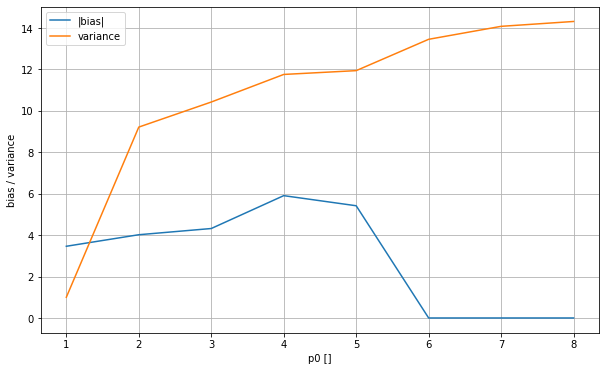

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p0_list, np.abs(bias_list), label="|bias|")
ax.plot(p0_list, variance_list, label="variance")
ax.set_xlabel("p0 []")
ax.set_ylabel("bias / variance")
ax.legend()
ax.grid()
plt.show()

As shown on the figure, the variance of a single estimation can only increase when adding new variables. Whereas there is not a similar rule for the bias. In this case the bias get worse when adding the second, third and fourth variables that are both useful and useless.

## Comparison frequentist vs bayesian approaches
We can only demonstrate that the variance is lower than in the frequentist approach. Nothing can be said regarding the bias. Following the same notation, we have:
$$\hat{Y}_{0i}=u^{T}\hat{Y_{0}} \sim \mathcal{N}(E[\hat{Y}_{0i}], \sigma^{2}u^{T}X_{0}(X_{0}^{T}X_{0} + \alpha I)^{-1}X_{0}^{T}X_{0}(X_{0}^{T}X_{0} + \alpha I)^{-1}X_{0}^{T}u)$$
Like previously, we can show that:
$$
u^{T}X_{0}(X_{0}^{T}X_{0} + \alpha I)^{-1}X_{0}^{T}X_{0}(X_{0}^{T}X_{0} + \alpha I)^{-1}X_{0}^{T}u - u^{T}X_{0}(X_{0}^{T}X_{0})^{-1}X_{0}^{T}u = u^{T}X_{0}P(D(D+\alpha I)^{-2}-D^{-1})P^{T}X_{0}^{T}u
$$
And:
$$\begin{align}
\forall i:(D(D+\alpha I)^{-2}-D^{-1})_{i,i} &= \frac{D_{i,i}}{(D_{i,i}+\alpha)^{2}}-\frac{1}{D_{i,i}}\\
&= \frac{D_{i,i}^{2}-(D_{i,i}+\alpha)^{2}}{D_{i,i}(D_{i,i}+\alpha)^{2}} < 0
\end{align}$$
**The variance of a single prediction is then always lower in the bayesian approach than in the frequentist approach.**

In [22]:
# parameters
alpha_freq = 0
alpha_bay = 40
index = 2

# initialization
bias_freq_list = []
variance_freq_list = []
bias_bay_list = []
variance_bay_list = []
p0_list = []

# loop over an increasing number of independent variables
for nb_x in range(1, X.shape[1] + 1):
    x_cols = list(range(nb_x))

    # frequentist approach
    p0, X0, biases, cov_mat = get_common_results(
        X, x_cols, X_beta, alpha_freq, sigma_noise
    )
    p0_list.append(p0)
    bias_freq_list.append(biases[index])
    variance_freq_list.append(cov_mat[index, index])

    # bayesian approach
    p0, X0, biases, cov_mat = get_common_results(
        X, x_cols, X_beta, alpha_bay, sigma_noise
    )
    bias_bay_list.append(biases[index])
    variance_bay_list.append(cov_mat[index, index])

<IPython.core.display.Javascript object>

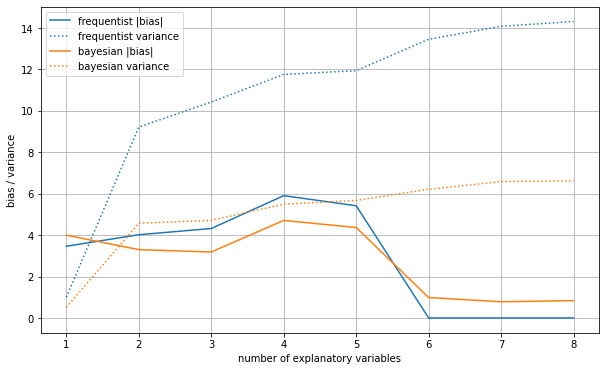

<IPython.core.display.Javascript object>

In [23]:
color_freq = "tab:blue"
color_bay = "tab:orange"
linestyle_bias = "-"
linestyle_var = ":"

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    p0_list,
    np.abs(bias_freq_list),
    label="frequentist |bias|",
    color=color_freq,
    linestyle=linestyle_bias,
)
ax.plot(
    p0_list,
    variance_freq_list,
    label="frequentist variance",
    color=color_freq,
    linestyle=linestyle_var,
)
ax.plot(
    p0_list,
    np.abs(bias_bay_list),
    label="bayesian |bias|",
    color=color_bay,
    linestyle=linestyle_bias,
)
ax.plot(
    p0_list,
    variance_bay_list,
    label="bayesian variance",
    color=color_bay,
    linestyle=linestyle_var,
)
ax.set_xlabel("number of explanatory variables")
ax.set_ylabel("bias / variance")
ax.legend()
ax.grid()
plt.show()

As shown on the figure, the variance of a single estimation is always lower in when there is a L2 regularization. However, there is no order between the biases between the two approaches for a single target estimation.

___
# Conclusion

In this notebook, I investigated the change of bias and variance of both a vector estimator and a scalar estimator of a linear regression model. When analyzing the vector estimators, two definitions have been considered (the scalar MSE and the matrix MSE). Finally, the results are summarized in the following table. The change of the bias and variance terms when adding explanatory variables are detailed in the table.

| Estimator | Metric | Approach | Bias | Variance |
| :---: | :---: | :---: | :---: | :---: |
| vector | matrix | frequentist | - | $\nearrow$ |
| vector | matrix | bayesian | - | - |
| vector | scalar | frequentist | $\searrow$ | $\nearrow$ |
| vector | scalar | bayesian | > frequentist | < frequentist<br>$\nearrow$? |
| scalar | scalar | frequentist | - | $\nearrow$ |
| scalar | scalar | bayesian | - | < frequentist<br>$\nearrow$? |